In [2]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem.MolStandardize.rdMolStandardize import ChargeParent 


In [204]:
df_ibacon = pd.read_csv('/home/cschiebroek/Downloads/ibacon round1.csv')
df_ibacon = df_ibacon.dropna(subset=['SMILES'])
df_ibacon['standardized_smiles'] = df_ibacon['SMILES'].apply(lambda x: Chem.MolToSmiles(ChargeParent(Chem.MolFromSmiles(x))) if Chem.MolFromSmiles(x) is not None else None)
df_ibacon

,Name,Cat.no.,Purity [%],ibacon No,SMILES,Canonical SMILES,standardized_smiles
0,Pyrrole,W338605,98.0,22875.0,c1cc[nH]c1,c1cc[nH]c1,c1cc[nH]c1
1,Methional,W274711,98.0,22876.0,CSCCC=O,CSCCC=O,CSCCC=O
2,2-Bromoethanol,B65586,95.0,22878.0,OCCBr,OCCBr,OCCBr
3,Propargyl alcohol,P50803,99.0,22880.0,C#CCO,C#CCO,C#CCO
4,Di-tert-butyl nitroxide,300721,90.0,22881.0,CC(C)(C)N([O])C(C)(C)C,CC(C)(C)N([O])C(C)(C)C,CC(C)(C)N([O])C(C)(C)C
...,...,...,...,...,...,...,...
75,Acetone cyanohydrin,A10000,99.0,22978.0,CC(C)(O)C#N,CC(C)(O)C#N,CC(C)(O)C#N
76,N-[3-(Dimethylamino)propyl]methacrylamide,409472,99.0,22979.0,C=C(C)C(=O)NCCCN(C)C,C=C(C)C(=O)NCCCN(C)C,C=C(C)C(=O)NCCCN(C)C
77,4-Methyl-3-penten-2-one,W336807,90.0,22980.0,CC(=O)C=C(C)C,CC(=O)C=C(C)C,CC(=O)C=C(C)C
78,Anabasine,284599,97.0,22981.0,c1cncc(C2CCCCN2)c1,c1cncc(C2CCCCN2)c1,c1cncc(C2CCCCN2)c1


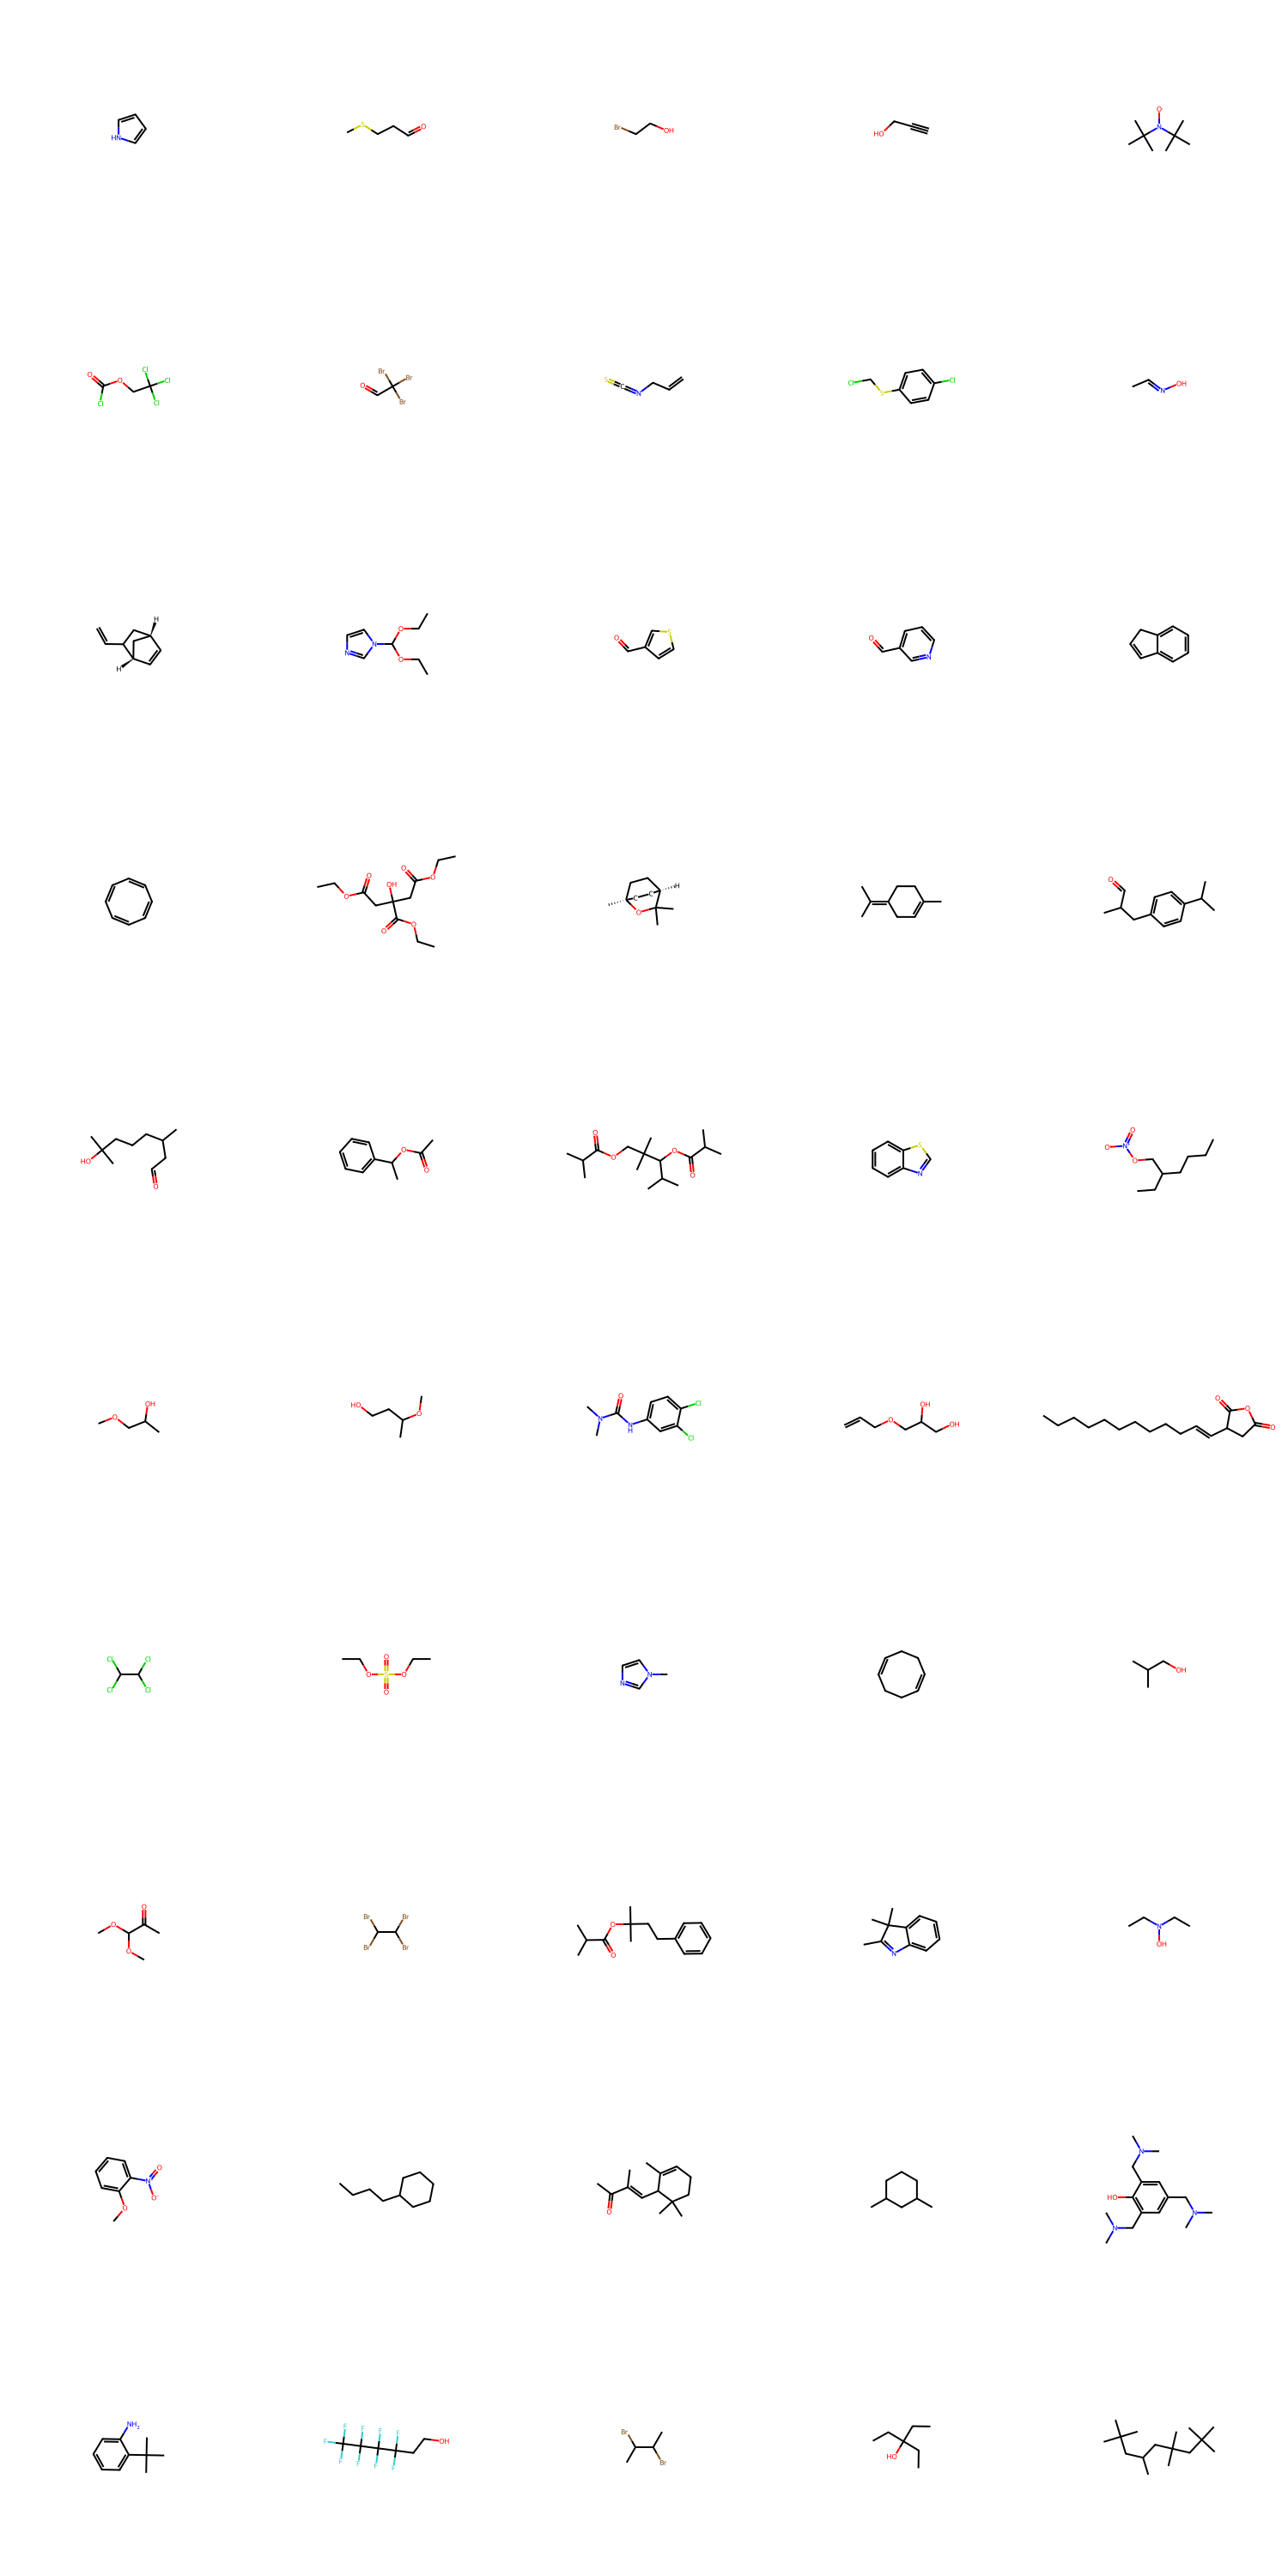

In [106]:
#draw
from rdkit.Chem import Draw
mols = [Chem.MolFromSmiles(x) for x in df_ibacon['standardized_smiles']]
Draw.MolsToGridImage([mol for mol in mols[:50]], molsPerRow=5, subImgSize=(300,300))

## To do
1. Generate starting conformer
2. Register appropriatly in DB
3. Run simulations
4. Predict

In [61]:
#lets register the others
from rdkit.Chem import rdmolops
from rdkit.Chem import AllChem
from rdkit import Chem
import json
import lwreg
from lwreg import standardization_lib
from lwreg import utils
config = lwreg.utils.defaultConfig()
# set the name of the database we'll work with:
config['dbtype'] = 'postgresql'
config['dbname'] = 'cs_mdfps'
config['host'] = 'lebanon'
config['user'] = 'cschiebroek'
config['password'] = '' # password is saved in our .pgpass
# we don't want to standardize the molecules:
config['standardization'] = standardization_lib.RemoveHs()
# we want to store conformers
config['registerConformers'] = True
cn = utils.connect(config)
cur = cn.cursor()
already_registered = set()
mol_list = []
molregno_list = []
for smi in df_ibacon['standardized_smiles']:
    print(smi)
    mol = Chem.AddHs(Chem.MolFromSmiles(smi))
    AllChem.EmbedMolecule(mol, enforceChirality=True, randomSeed=0xf00d)
    rdmolops.AssignStereochemistryFrom3D(mol)
    used_smiles = Chem.MolToSmiles(mol, isomericSmiles=True)
    mol.SetProp("_Name", used_smiles)
    mol.UpdatePropertyCache(strict=False)
    #register mol
    try:
        lwreg.register(config=config,mol=mol)
    except:
        print('registration failed for: ',smi)
        continue
    #get molregno
    hits = lwreg.query(smiles=used_smiles,config=config)
    try:
        molregno = hits[0]
    except IndexError:
        print('query failed for: ',smi)
        continue
    #store molregno
    already_registered.add(molregno)
    mol_list.append(mol)
    molregno_list.append(molregno)
      
# cn.commit()



c1cc[nH]c1
registration failed for:  c1cc[nH]c1
CSCCC=O
registration failed for:  CSCCC=O
OCCBr
registration failed for:  OCCBr
C#CCO
registration failed for:  C#CCO
CC(C)(C)N([O])C(C)(C)C
registration failed for:  CC(C)(C)N([O])C(C)(C)C
O=C(Cl)OCC(Cl)(Cl)Cl
registration failed for:  O=C(Cl)OCC(Cl)(Cl)Cl
O=CC(Br)(Br)Br
registration failed for:  O=CC(Br)(Br)Br
C=CCN=C=S
registration failed for:  C=CCN=C=S
ClCSc1ccc(Cl)cc1
registration failed for:  ClCSc1ccc(Cl)cc1
C/C=N/O
registration failed for:  C/C=N/O
C=CC1C[C@@H]2C=C[C@H]1C2
registration failed for:  C=CC1C[C@@H]2C=C[C@H]1C2
CCOC(OCC)n1ccnc1
registration failed for:  CCOC(OCC)n1ccnc1
O=Cc1ccsc1
registration failed for:  O=Cc1ccsc1
O=Cc1cccnc1
registration failed for:  O=Cc1cccnc1
C1=Cc2ccccc2C1
registration failed for:  C1=Cc2ccccc2C1
C1=C\C=C/C=C\C=C/1
registration failed for:  C1=C\C=C/C=C\C=C/1
CCOC(=O)CC(O)(CC(=O)OCC)C(=O)OCC
registration failed for:  CCOC(=O)CC(O)(CC(=O)OCC)C(=O)OCC
CC1(C)O[C@]2(C)CC[C@H]1CC2
registration fail

In [29]:
#query, get molregno, all confids, and the confid for this specific conformer
molregno_to_all_confids = {}
molregno_to_latest_confid = {}
for molregno in already_registered:
    hits = lwreg.query(ids=[molregno],config=config)
    molregno_to_all_confids[molregno] = [hit[1] for hit in hits]
    molregno_to_latest_confid[molregno] = max(molregno_to_all_confids[molregno])
molregno_to_all_confids    

{3611: [3609, 5903, 5904, 5905, 5906, 5907, 17144, 17208, 17312],
 4124: [4122, 14392, 14391, 17346],
 2596: [2594, 6216, 6217, 6218, 6219, 6220, 17330],
 3648: [3646, 15170, 15171, 15172, 17323],
 4162: [4160, 8400, 8401, 8402, 17299],
 2633: [2631, 12258, 17301],
 101: [1246, 15194, 15195, 15196, 15197, 15198, 17321],
 2669: [2667, 5104, 5105, 5106, 5107, 5108, 17310],
 109: [1254, 6721, 6719, 6720, 17333],
 645: [1790, 12515, 17344],
 3207: [3205, 7026, 17339],
 17055: [17053, 17296],
 3248: [3246, 9858, 9859, 9856, 9857, 17316],
 2763: [2761, 6330, 6331, 6332, 6333, 6334, 17285],
 3295: [17269, 3293, 13250],
 3807: [3805, 8842, 8843, 8844, 17334],
 2318: [2316, 9809, 9810, 9811, 17332],
 3358: [17284, 16935],
 16676: [16674, 17294],
 299: [1444, 5050, 5051, 5049, 17324],
 824: [1969, 6057, 6058, 6059, 6060, 6061, 17279],
 16709: [16707, 17331],
 2899: [2897, 6663, 6664, 6665, 6666, 17286, 17262],
 859: [2004, 12490, 12491, 12492, 12493, 12494, 17327],
 16740: [17275, 16738],
 3951:

In [35]:
molregnos = tuple(molregno_to_latest_confid.keys())
molregnos

(3611,
 4124,
 2596,
 3648,
 4162,
 2633,
 101,
 2669,
 109,
 645,
 3207,
 17055,
 3248,
 2763,
 3295,
 3807,
 2318,
 3358,
 16676,
 299,
 824,
 16709,
 2899,
 859,
 16740,
 3951,
 17272,
 17273,
 17275,
 17276,
 16766,
 17278,
 17280,
 17279,
 17282,
 17283,
 17284,
 3458,
 17290,
 17291,
 17292,
 17293,
 17294,
 17295,
 16783,
 17297,
 2442,
 17299,
 17300,
 17306,
 17308,
 17309,
 925,
 17313,
 17315,
 17316,
 17317,
 17319,
 17320,
 17322,
 17324,
 16302,
 17328,
 17337,
 17338,
 17343,
 17344,
 961,
 17345,
 17347,
 17349,
 16840,
 2510,
 3535,
 3024,
 988,
 16353,
 16880,
 2554)

In [ ]:
#now check for each molregno if there is a confid 

In [38]:
#find all conf_ids that are NOT in cs_mdfps_schema.confid_data;
import psycopg2
conn = psycopg2.connect("dbname=cs_mdfps user=cschiebroek host=lebanon")
cur = conn.cursor()
query =  f"""
SELECT c.molregno, c.conf_id, e.md_experiment_uuid
FROM conformers c
JOIN cs_mdfps_schema.mdfp_experiment_data e
  ON c.conf_id = e.conf_id 
WHERE c.molregno IN {molregnos};

"""

cur.execute(query)
data = cur.fetchall()
data

[(109, 1254, 'fc57851e-b654-4338-bcdd-faa28ec66253'),
 (101, 1246, 'fc57851e-b654-4338-bcdd-faa28ec66253'),
 (299, 1444, 'fc57851e-b654-4338-bcdd-faa28ec66253'),
 (824, 1969, 'fc57851e-b654-4338-bcdd-faa28ec66253'),
 (859, 2004, 'fc57851e-b654-4338-bcdd-faa28ec66253'),
 (988, 2132, 'fc57851e-b654-4338-bcdd-faa28ec66253'),
 (2442, 2440, 'fc57851e-b654-4338-bcdd-faa28ec66253'),
 (2633, 2631, 'fc57851e-b654-4338-bcdd-faa28ec66253'),
 (2510, 2508, 'fc57851e-b654-4338-bcdd-faa28ec66253'),
 (2318, 2316, 'fc57851e-b654-4338-bcdd-faa28ec66253'),
 (645, 1790, 'fc57851e-b654-4338-bcdd-faa28ec66253'),
 (961, 2105, 'fc57851e-b654-4338-bcdd-faa28ec66253'),
 (925, 2070, 'fc57851e-b654-4338-bcdd-faa28ec66253'),
 (2554, 2552, 'fc57851e-b654-4338-bcdd-faa28ec66253'),
 (2596, 2594, 'fc57851e-b654-4338-bcdd-faa28ec66253'),
 (2669, 2667, 'fc57851e-b654-4338-bcdd-faa28ec66253'),
 (2763, 2761, 'fc57851e-b654-4338-bcdd-faa28ec66253'),
 (2899, 2897, 'fc57851e-b654-4338-bcdd-faa28ec66253'),
 (3024, 3022, 'fc57

In [39]:
#to df
df = pd.DataFrame(data, columns=['molregno','conf_id','md_experiment_uuid'])
df

,molregno,conf_id,md_experiment_uuid
0,109,1254,fc57851e-b654-4338-bcdd-faa28ec66253
1,101,1246,fc57851e-b654-4338-bcdd-faa28ec66253
2,299,1444,fc57851e-b654-4338-bcdd-faa28ec66253
3,824,1969,fc57851e-b654-4338-bcdd-faa28ec66253
4,859,2004,fc57851e-b654-4338-bcdd-faa28ec66253
...,...,...,...
235,3458,3456,5166be97-ef21-4cc5-bee1-719c7b9e3397
236,16676,16674,5166be97-ef21-4cc5-bee1-719c7b9e3397
237,3807,3805,5166be97-ef21-4cc5-bee1-719c7b9e3397
238,925,2070,5166be97-ef21-4cc5-bee1-719c7b9e3397


In [41]:
#count number of unique molregnos
print(len(df['molregno'].unique()))
df['molregno'].value_counts()

41


molregno
3458     9
2596     9
859      9
2510     9
2763     9
3535     9
925      9
2669     9
3611     8
824      8
2899     8
101      7
3648     7
3807     7
961      7
2554     7
2318     7
4162     7
2442     7
988      7
299      7
4124     6
3248     6
109      5
3951     5
3024     5
645      5
3295     5
16676    3
16840    3
16766    3
17055    3
16880    3
16302    3
16783    3
16709    3
16353    3
2633     3
3207     3
3358     3
16740    1
Name: count, dtype: int64

In [47]:
md_experiment_uuids_to_drop = ['5166be97-ef21-4cc5-bee1-719c7b9e3397','24e3946b-fb2c-47bf-9965-1682bb0d63c9','80b643c8-5bdc-4b63-a12d-6f1ba3f7dd2a','e0f120fb-efa9-4c88-a964-e7b99253027c']
df = df[~df['md_experiment_uuid'].isin(md_experiment_uuids_to_drop)]
df

,molregno,conf_id,md_experiment_uuid
0,109,1254,fc57851e-b654-4338-bcdd-faa28ec66253
1,101,1246,fc57851e-b654-4338-bcdd-faa28ec66253
2,299,1444,fc57851e-b654-4338-bcdd-faa28ec66253
3,824,1969,fc57851e-b654-4338-bcdd-faa28ec66253
4,859,2004,fc57851e-b654-4338-bcdd-faa28ec66253
5,988,2132,fc57851e-b654-4338-bcdd-faa28ec66253
6,2442,2440,fc57851e-b654-4338-bcdd-faa28ec66253
7,2633,2631,fc57851e-b654-4338-bcdd-faa28ec66253
8,2510,2508,fc57851e-b654-4338-bcdd-faa28ec66253
9,2318,2316,fc57851e-b654-4338-bcdd-faa28ec66253


In [137]:
df['md_experiment_uuid'].value_counts()

md_experiment_uuid
fc57851e-b654-4338-bcdd-faa28ec66253    30
26dee5cf-c401-4924-9c43-6e5f8f311763    11
Name: count, dtype: int64

In [139]:
#get confids_already_simulated
confids_already_simulated = tuple(set(df['conf_id']))
confids_already_simulated

(3456,
 3205,
 2440,
 2316,
 16781,
 2070,
 3609,
 4122,
 17053,
 2594,
 16674,
 1444,
 16935,
 16300,
 3246,
 1969,
 2105,
 3646,
 4160,
 16707,
 16838,
 2631,
 2761,
 2508,
 3533,
 3022,
 2897,
 2004,
 2132,
 3293,
 1246,
 3805,
 16351,
 16738,
 1254,
 2667,
 3949,
 16878,
 2552,
 16764,
 1790)

In [95]:
#get number of unique molregnos from this one
print(len(df['molregno'].unique()))

41


In [44]:
#find all conf_ids that are NOT in cs_mdfps_schema.confid_data;
import psycopg2
conn = psycopg2.connect("dbname=cs_mdfps user=cschiebroek host=lebanon")
cur = conn.cursor()
query =  f"""
SELECT md_experiment_uuid, COUNT(*) AS entry_count
FROM cs_mdfps_schema.mdfp_experiment_data
GROUP BY md_experiment_uuid;


"""

cur.execute(query)
data = cur.fetchall()
data

[('80b643c8-5bdc-4b63-a12d-6f1ba3f7dd2a', 2973),
 ('24e3946b-fb2c-47bf-9965-1682bb0d63c9', 2895),
 ('fc57851e-b654-4338-bcdd-faa28ec66253', 2980),
 ('af2fb76d-c5bc-4cc5-bc86-20718989283e', 1),
 ('e0f120fb-efa9-4c88-a964-e7b99253027c', 11028),
 ('5166be97-ef21-4cc5-bee1-719c7b9e3397', 2847),
 ('26dee5cf-c401-4924-9c43-6e5f8f311763', 1123)]

In [52]:
#get keys from molregno_to_all_confids, where the len of value list > 1
molregnos_multiple_confs = {k:v for k,v in molregno_to_all_confids.items() if len(v) > 1}
len(molregnos_multiple_confs)

41

In [53]:
#and get the ones with one conf
molregnos_single_conf = {k:v for k,v in molregno_to_all_confids.items() if len(v) == 1}
len(molregnos_single_conf)

38

In [54]:
molregnos_single_conf

{17272: [17270],
 17273: [17271],
 17275: [17273],
 17276: [17274],
 17278: [17276],
 17280: [17278],
 17279: [17277],
 17282: [17280],
 17283: [17281],
 17284: [17282],
 17290: [17288],
 17291: [17289],
 17292: [17290],
 17293: [17291],
 17294: [17292],
 17295: [17293],
 17297: [17295],
 17299: [17297],
 17300: [17298],
 17306: [17304],
 17308: [17306],
 17309: [17307],
 17313: [17311],
 17315: [17313],
 17316: [17314],
 17317: [17315],
 17319: [17317],
 17320: [17318],
 17322: [17320],
 17324: [17322],
 17328: [17326],
 17337: [17335],
 17338: [17336],
 17343: [17341],
 17344: [17342],
 17345: [17343],
 17347: [17345],
 17349: [17347]}

In [58]:
#get list of tuples of molregno-confid pairs
molregno_confid_pairs = [(k,v[0]) for k,v in molregnos_single_conf.items()]
molregno_confid_pairs

[(17272, 17270),
 (17273, 17271),
 (17275, 17273),
 (17276, 17274),
 (17278, 17276),
 (17280, 17278),
 (17279, 17277),
 (17282, 17280),
 (17283, 17281),
 (17284, 17282),
 (17290, 17288),
 (17291, 17289),
 (17292, 17290),
 (17293, 17291),
 (17294, 17292),
 (17295, 17293),
 (17297, 17295),
 (17299, 17297),
 (17300, 17298),
 (17306, 17304),
 (17308, 17306),
 (17309, 17307),
 (17313, 17311),
 (17315, 17313),
 (17316, 17314),
 (17317, 17315),
 (17319, 17317),
 (17320, 17318),
 (17322, 17320),
 (17324, 17322),
 (17328, 17326),
 (17337, 17335),
 (17338, 17336),
 (17343, 17341),
 (17344, 17342),
 (17345, 17343),
 (17347, 17345),
 (17349, 17347)]

In [63]:
#query these to get the mols
querie = lwreg.retrieve(ids=molregno_confid_pairs,config=config)
querie

{(17272,
  17270): ('[H]C(=O)C([H])([H])C([H])([H])SC([H])([H])[H]\n     RDKit          3D\n\n  0  0  0  0  0  0  0  0  0  0999 V3000\nM  V30 BEGIN CTAB\nM  V30 COUNTS 6 5 0 0 0\nM  V30 BEGIN ATOM\nM  V30 1 C -1.971255 -0.052967 -0.835918 0\nM  V30 2 S -0.800161 1.260850 -0.391474 0\nM  V30 3 C 0.049172 0.728152 1.120015 0\nM  V30 4 C 0.920795 -0.501818 0.829976 0\nM  V30 5 C 1.922032 -0.142696 -0.199344 0\nM  V30 6 O 2.744342 -0.957947 -0.607120 0\nM  V30 END ATOM\nM  V30 BEGIN BOND\nM  V30 1 1 1 2\nM  V30 2 1 2 3\nM  V30 3 1 3 4\nM  V30 4 1 4 5\nM  V30 5 2 5 6\nM  V30 END BOND\nM  V30 END CTAB\nM  END\n', 'mol'),
 (17273,
  17271): ('[H]OC([H])([H])C([H])([H])Br\n     RDKit          3D\n\n  0  0  0  0  0  0  0  0  0  0999 V3000\nM  V30 BEGIN CTAB\nM  V30 COUNTS 4 3 0 0 0\nM  V30 BEGIN ATOM\nM  V30 1 O -1.107104 0.980573 0.359960 0\nM  V30 2 C -0.746114 -0.268987 -0.150127 0\nM  V30 3 C 0.743642 -0.426486 0.181106 0\nM  V30 4 Br 1.620665 1.065556 -0.724240 0\nM  V30 END ATOM\nM  V30 B

In [73]:
import os
for confid, molblock in querie.items():
    print(f'confid: {confid[1]}')
    print(f'molblock: {molblock[0]}')
    mol = Chem.MolFromMolBlock(molblock[0])
    #save as .mol
    #we dont want to overwrite, assert path does not exist yet
    assert not os.path.exists(f'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/mols_3d/{confid[1]}.mol')
    with open(f'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/mols_3d/{confid[1]}.mol', 'w') as f:
        f.write(molblock[0])
        

confid: 17270
molblock: [H]C(=O)C([H])([H])C([H])([H])SC([H])([H])[H]
     RDKit          3D

  0  0  0  0  0  0  0  0  0  0999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 6 5 0 0 0
M  V30 BEGIN ATOM
M  V30 1 C -1.971255 -0.052967 -0.835918 0
M  V30 2 S -0.800161 1.260850 -0.391474 0
M  V30 3 C 0.049172 0.728152 1.120015 0
M  V30 4 C 0.920795 -0.501818 0.829976 0
M  V30 5 C 1.922032 -0.142696 -0.199344 0
M  V30 6 O 2.744342 -0.957947 -0.607120 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 1 2
M  V30 2 1 2 3
M  V30 3 1 3 4
M  V30 4 1 4 5
M  V30 5 2 5 6
M  V30 END BOND
M  V30 END CTAB
M  END

confid: 17271
molblock: [H]OC([H])([H])C([H])([H])Br
     RDKit          3D

  0  0  0  0  0  0  0  0  0  0999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 4 3 0 0 0
M  V30 BEGIN ATOM
M  V30 1 O -1.107104 0.980573 0.359960 0
M  V30 2 C -0.746114 -0.268987 -0.150127 0
M  V30 3 C 0.743642 -0.426486 0.181106 0
M  V30 4 Br 1.620665 1.065556 -0.724240 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 1 2
M  V30 2 1 2 3

In [74]:
confid_list = [confid[1] for confid in molregno_confid_pairs]
confid_list

[17270,
 17271,
 17273,
 17274,
 17276,
 17278,
 17277,
 17280,
 17281,
 17282,
 17288,
 17289,
 17290,
 17291,
 17292,
 17293,
 17295,
 17297,
 17298,
 17304,
 17306,
 17307,
 17311,
 17313,
 17314,
 17315,
 17317,
 17318,
 17320,
 17322,
 17326,
 17335,
 17336,
 17341,
 17342,
 17343,
 17345,
 17347]

In [75]:
len(confid_list)

38

In [93]:
#these are 38, and we already did 41, but means one is missing, find out which one
molregnos_accounted_for = list(molregno_to_all_confids.keys())
len(molregnos_accounted_for)
#query all smiles again, and check which one is missing
for smiles in df_ibacon['standardized_smiles']:
    try:
        molregno = lwreg.query(smiles=smiles,config=config)[0]
    except IndexError:
        print(smiles)
        continue
    if molregno not in molregnos_accounted_for:
        print(smiles)
        print(molregno)
        break
    

C=CC1C[C@@H]2C=C[C@H]1C2
CC(C=O)Cc1ccc(C(C)C)cc1
CC(CC=O)CCCC(C)(C)O
CC(=O)OC(C)c1ccccc1
CC(C)C(=O)OCC(C)(C)C(OC(=O)C(C)C)C(C)C
CCCCC(CC)CO[N+](=O)[O-]
COCC(C)O
COC(C)CCO
C=CCOCC(O)CO
CCCCCCCCCC/C=C/C1CC(=O)OC1=O
C1=C\CC/C=C\CC/1
84


In [94]:
lwreg.query(smiles='C1=C\CC/C=C\CC/1',config=config)[0]

84

In [199]:
lwreg.query(smiles='C1=C\CC/C=C\CC/1',config=config)[0]

84

In [96]:
#check if 84 in df molregno
84 in df['molregno'].values

False

In [97]:
lwreg.query(ids=[84],config=config)[0]

(84, 16786)

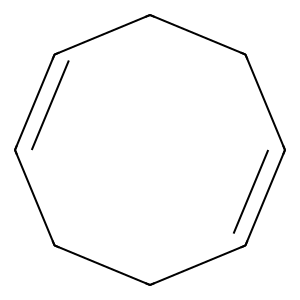

In [103]:
from rdkit.Chem import Draw
mola = Chem.MolFromSmiles('C1=C\CC/C=C\CC/1')
Draw.MolToImage(mola)

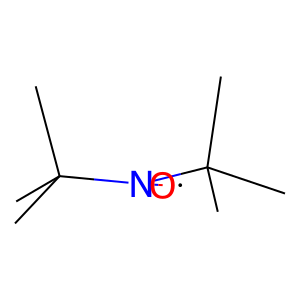

In [105]:
#sim failed for conf_id 17273, lets look at the mol, load from mol file
mola = Chem.MolFromMolFile('/localhome/cschiebroek/MDFP_VP/mdfptools/carl/mols_3d/17273.mol')
Draw.MolToImage(mola)

In [108]:
#get substr match for smiles in df_ibacon
smarts = Chem.MolToSmarts(mola)
mols_ibacon = [Chem.MolFromSmiles(x) for x in df_ibacon['standardized_smiles']]
for m in mols_ibacon:
    if m.HasSubstructMatch(mola):
        print(Chem.MolToSmiles(m))
        break


CC(C)(C)N([O])C(C)(C)C


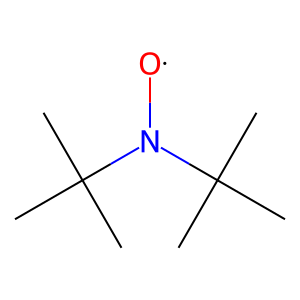

In [112]:
mol_orignial = Chem.MolFromSmiles('CC(C)(C)N([O])C(C)(C)C')
Draw.MolToImage(mol_orignial) 


In [113]:
#find in df
df_ibacon[df_ibacon['standardized_smiles'] == 'CC(C)(C)N([O])C(C)(C)C']

,Name,Cat.no.,Purity [%],ibacon No,SMILES,Canonical SMILES,standardized_smiles
4,Di-tert-butyl nitroxide,300721,90.0,22881.0,CC(C)(C)N([O])C(C)(C)C,CC(C)(C)N([O])C(C)(C)C,CC(C)(C)N([O])C(C)(C)C


these are the ones we still need to simulate

In [161]:
#load simulations; ran on Euler


conn = psycopg2.connect("dbname=cs_mdfps user=cschiebroek host=lebanon")
cur = conn.cursor()
query =  f"""
SELECT e.mdfp, e.conf_id, c.molregno
FROM cs_mdfps_schema.mdfp_experiment_data e
JOIN conformers c ON e.conf_id = c.conf_id
WHERE e.md_experiment_uuid = '13d08336-fb79-4042-83ce-af906193ff20'
   OR (e.conf_id IN {confids_already_simulated}
       AND e.md_experiment_uuid IN ('fc57851e-b654-4338-bcdd-faa28ec66253', '26dee5cf-c401-4924-9c43-6e5f8f311763'));
"""

cur.execute(query)
data = cur.fetchall()
data

[({'mdfp': '[4, 1, 0, 0, 0, 0, 0, 1, 1, 0, 2.0953226426886893, 1.0630604130473953, 2.144359610053673, 0.8112254927164844, 1.2229329622317384, 0.43936228642319686, -19.733297075148258, 7.238295120453924, -19.663822452714957, -33.75875885559798, 5.445962890058485, -34.54383124862866, 2.906548135405174, 1.9126036101597388, 2.509684281660265, -53.49205593074624, 8.211556536911678, -53.9694922993616, 0.20086026465927642, 0.003305676767110135, 0.2006580617247022, 2.3654788, 0.014913022, 2.3651352]'},
  1254,
  109),
 ({'mdfp': '[6, 2, 0, 2, 0, 0, 0, 0, 0, 0, -13.945181232005933, 5.75384345943795, -13.577389429441226, 4.32821739423299, 3.6174849685686863, 3.6415490553152337, -135.7118524737567, 21.22326128370884, -136.75821276191311, -16.007375033589174, 11.747046602205778, -17.257255538630382, -9.616963837772943, 6.115030912602434, -9.876305543898916, -151.71922750734586, 16.559831807444183, -150.9953616950541, 0.1999645985480859, 0.009672508112711973, 0.2007993177219309, 2.650665, 0.0356304

In [162]:
len(data)

79

In [163]:
#get confids and mdfps
confids = [x[1] for x in data]
mdfps = [x[0] for x in data]
molregnos = [x[2] for x in data]
confids, mdfps, molregnos

([1254,
  1246,
  1444,
  1969,
  2004,
  2132,
  2440,
  2631,
  2508,
  2316,
  1790,
  2105,
  2070,
  2552,
  2594,
  2667,
  2761,
  2897,
  3022,
  3205,
  3246,
  3293,
  3456,
  3949,
  3533,
  3609,
  3646,
  3805,
  4122,
  4160,
  16351,
  16707,
  16300,
  16781,
  16674,
  16878,
  17053,
  16738,
  16764,
  16838,
  16935,
  16786,
  17270,
  17271,
  17274,
  17276,
  17278,
  17277,
  17280,
  17281,
  17282,
  17288,
  17289,
  17290,
  17291,
  17292,
  17293,
  17295,
  17297,
  17298,
  17304,
  17306,
  17307,
  17311,
  17313,
  17314,
  17315,
  17317,
  17318,
  17320,
  17322,
  17326,
  17335,
  17336,
  17341,
  17342,
  17343,
  17345,
  17347],
 [{'mdfp': '[4, 1, 0, 0, 0, 0, 0, 1, 1, 0, 2.0953226426886893, 1.0630604130473953, 2.144359610053673, 0.8112254927164844, 1.2229329622317384, 0.43936228642319686, -19.733297075148258, 7.238295120453924, -19.663822452714957, -33.75875885559798, 5.445962890058485, -34.54383124862866, 2.906548135405174, 1.91260361015973

In [164]:
mdfps = [json.loads(x['mdfp']) for x in mdfps]

In [149]:
#save to df;
mdfp_features_all = ['NumHeavyAtoms', 'NumRotatableBonds', 'NumN', 'NumO', 'NumF', 'NumP', 'NumS', 'NumCl', 'NumBr', 'NumI',
                     'water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean',
                     'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std',
                     'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median',
                     'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean',
                     'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std',
                     'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']
mdfp_df = pd.DataFrame(mdfps, columns=mdfp_features_all)
X_val = mdfp_df[mdfp_features_all]

In [150]:
import xgboost as xgb
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pred_list = []
for i in range(10):
    model = xgb.Booster()
    model.load_model(f'models/XGBOOST_MDFP_{i}.json')
    dval = xgb.DMatrix(X_val)
    preds = model.predict(dval)
    pred_list.append(preds)


In [168]:
#write mean, 90% CI (lower and upper) to df (per confid)
import numpy as np
pred_list = np.array(pred_list)
mean_preds = np.mean(pred_list, axis=0)
lower_bound = np.percentile(pred_list, 5, axis=0)
upper_bound = np.percentile(pred_list, 95, axis=0)
df_preds = pd.DataFrame({'conf_id':confids, 'molregno':molregnos, 'Mean_Pred_XGBOOST_MDFP_solution':mean_preds, 'CI5_Pred_XGBOOST_MDFP_solution':lower_bound, 'CI95_Pred_XGBOOST_MDFP_solution':upper_bound})
df_preds

,conf_id,molregno,Mean_Pred_XGBOOST_MDFP_solution,CI5_Pred_XGBOOST_MDFP_solution,CI95_Pred_XGBOOST_MDFP_solution
0,1254,109,4.077861,3.640882,4.582443
1,1246,101,1.214397,0.716225,1.754912
2,1444,299,3.304140,3.236458,3.319933
3,1969,824,3.086105,2.958914,3.118260
4,2004,859,3.038960,2.678334,3.129373
...,...,...,...,...,...
74,17341,17343,3.076959,2.429415,3.396268
75,17342,17344,3.232969,2.755964,3.701902
76,17343,17345,1.167545,0.847999,1.581813
77,17345,17347,-0.741370,-1.599266,0.385312


Text(0, 0.5, 'mean_pred')

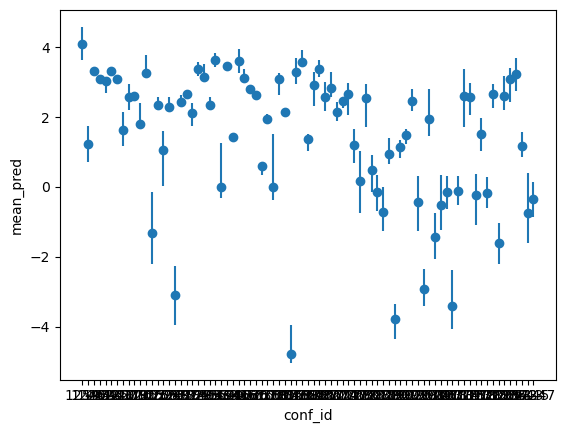

In [166]:
#plot confids vs mean_pred with error bars
import matplotlib.pyplot as plt
df_preds['conf_id'] = df_preds['conf_id'].astype(str)
plt.errorbar(df_preds['conf_id'], df_preds['mean_pred'], yerr=[df_preds['mean_pred'] - df_preds['lower_bound'], df_preds['upper_bound'] - df_preds['mean_pred']], fmt='o')
plt.xlabel('conf_id')
plt.ylabel('mean_pred')

In [169]:
#add bool in_train true/false   
#create set molregnos_train
molregnos_train = set()
for i in range(10):
    df_train = pd.read_csv('splits/OPERA_Naef_Training_condensed_'+str(i)+'.csv')
    df_val = pd.read_csv('splits/OPERA_Naef_Validation_condensed_'+str(i)+'.csv')
    molregnos_train.update(df_train['molregno'].values)
    molregnos_train.update(df_val['molregno'].values)

{16384,
 1,
 16386,
 16387,
 16388,
 16389,
 16385,
 16390,
 16392,
 16393,
 16394,
 16395,
 12,
 16397,
 16398,
 15,
 16400,
 16401,
 18,
 19,
 20,
 16405,
 16404,
 16406,
 24,
 22,
 23,
 21,
 28,
 16413,
 30,
 26,
 16412,
 25,
 16418,
 16419,
 36,
 37,
 35,
 16420,
 40,
 41,
 8,
 44,
 45,
 16428,
 47,
 16432,
 16433,
 50,
 51,
 9,
 53,
 58,
 59,
 60,
 65,
 66,
 67,
 68,
 16452,
 70,
 14,
 71,
 73,
 76,
 16460,
 79,
 16463,
 81,
 82,
 84,
 16469,
 16470,
 86,
 88,
 89,
 16468,
 91,
 92,
 16475,
 16477,
 96,
 97,
 98,
 16482,
 100,
 16485,
 102,
 105,
 106,
 107,
 16492,
 16493,
 108,
 110,
 16489,
 113,
 16498,
 115,
 16500,
 114,
 16499,
 118,
 120,
 16505,
 121,
 123,
 16507,
 122,
 126,
 124,
 119,
 129,
 132,
 135,
 136,
 16520,
 138,
 16523,
 140,
 141,
 16522,
 16527,
 146,
 147,
 148,
 150,
 151,
 153,
 158,
 161,
 163,
 16547,
 165,
 167,
 16551,
 16554,
 170,
 172,
 175,
 16561,
 16562,
 180,
 16566,
 184,
 185,
 186,
 188,
 189,
 190,
 191,
 16577,
 193,
 16579,
 16580,
 165

In [172]:
#create column in_train bool
df_preds['in_train'] = df_preds['molregno'].apply(lambda x: x in molregnos_train)
df_preds

,conf_id,molregno,Mean_Pred_XGBOOST_MDFP_solution,CI5_Pred_XGBOOST_MDFP_solution,CI95_Pred_XGBOOST_MDFP_solution,in_train
0,1254,109,4.077861,3.640882,4.582443,False
1,1246,101,1.214397,0.716225,1.754912,False
2,1444,299,3.304140,3.236458,3.319933,True
3,1969,824,3.086105,2.958914,3.118260,True
4,2004,859,3.038960,2.678334,3.129373,True
...,...,...,...,...,...,...
74,17341,17343,3.076959,2.429415,3.396268,False
75,17342,17344,3.232969,2.755964,3.701902,False
76,17343,17345,1.167545,0.847999,1.581813,False
77,17345,17347,-0.741370,-1.599266,0.385312,False


In [177]:
df_ibacon

,Name,Cat.no.,Purity [%],ibacon No,SMILES,Canonical SMILES,standardized_smiles
0,Pyrrole,W338605,98.0,22875.0,c1cc[nH]c1,c1cc[nH]c1,c1cc[nH]c1
1,Methional,W274711,98.0,22876.0,CSCCC=O,CSCCC=O,CSCCC=O
2,2-Bromoethanol,B65586,95.0,22878.0,OCCBr,OCCBr,OCCBr
3,Propargyl alcohol,P50803,99.0,22880.0,C#CCO,C#CCO,C#CCO
4,Di-tert-butyl nitroxide,300721,90.0,22881.0,CC(C)(C)N([O])C(C)(C)C,CC(C)(C)N([O])C(C)(C)C,CC(C)(C)N([O])C(C)(C)C
...,...,...,...,...,...,...,...
75,Acetone cyanohydrin,A10000,99.0,22978.0,CC(C)(O)C#N,CC(C)(O)C#N,CC(C)(O)C#N
76,N-[3-(Dimethylamino)propyl]methacrylamide,409472,99.0,22979.0,C=C(C)C(=O)NCCCN(C)C,C=C(C)C(=O)NCCCN(C)C,C=C(C)C(=O)NCCCN(C)C
77,4-Methyl-3-penten-2-one,W336807,90.0,22980.0,CC(=O)C=C(C)C,CC(=O)C=C(C)C,CC(=O)C=C(C)C
78,Anabasine,284599,97.0,22981.0,c1cncc(C2CCCCN2)c1,c1cncc(C2CCCCN2)c1,c1cncc(C2CCCCN2)c1


In [181]:
molregnos = []
for smi in df_ibacon['standardized_smiles']:
    try:
        molregno = lwreg.query(smiles=smi,config=config)[0]
        molregnos.append(molregno)
    except IndexError:
        molregnos.append(None)
        print(smi)
df_ibacon['molregno'] = molregnos
df_ibacon

C=CC1C[C@@H]2C=C[C@H]1C2
CC(C=O)Cc1ccc(C(C)C)cc1
CC(CC=O)CCCC(C)(C)O
CC(=O)OC(C)c1ccccc1
CC(C)C(=O)OCC(C)(C)C(OC(=O)C(C)C)C(C)C
CCCCC(CC)CO[N+](=O)[O-]
COCC(C)O
COC(C)CCO
C=CCOCC(O)CO
CCCCCCCCCC/C=C/C1CC(=O)OC1=O
CC(=O)/C(C)=C/C1C(C)=CCCC1(C)C
CC1CCCC(C)C1
CC(Br)C(C)Br
CC(CC(C)(C)C)CC(C)(C)CC(C)(C)C
CC1OC(C)OC(C)O1
c1cncc(C2CCCCN2)c1
CC(C)C(C)O


,Name,Cat.no.,Purity [%],ibacon No,SMILES,Canonical SMILES,standardized_smiles,molregno
0,Pyrrole,W338605,98.0,22875.0,c1cc[nH]c1,c1cc[nH]c1,c1cc[nH]c1,3295.0
1,Methional,W274711,98.0,22876.0,CSCCC=O,CSCCC=O,CSCCC=O,17272.0
2,2-Bromoethanol,B65586,95.0,22878.0,OCCBr,OCCBr,OCCBr,17273.0
3,Propargyl alcohol,P50803,99.0,22880.0,C#CCO,C#CCO,C#CCO,988.0
4,Di-tert-butyl nitroxide,300721,90.0,22881.0,CC(C)(C)N([O])C(C)(C)C,CC(C)(C)N([O])C(C)(C)C,CC(C)(C)N([O])C(C)(C)C,17275.0
...,...,...,...,...,...,...,...,...
75,Acetone cyanohydrin,A10000,99.0,22978.0,CC(C)(O)C#N,CC(C)(O)C#N,CC(C)(O)C#N,645.0
76,N-[3-(Dimethylamino)propyl]methacrylamide,409472,99.0,22979.0,C=C(C)C(=O)NCCCN(C)C,C=C(C)C(=O)NCCCN(C)C,C=C(C)C(=O)NCCCN(C)C,17347.0
77,4-Methyl-3-penten-2-one,W336807,90.0,22980.0,CC(=O)C=C(C)C,CC(=O)C=C(C)C,CC(=O)C=C(C)C,4124.0
78,Anabasine,284599,97.0,22981.0,c1cncc(C2CCCCN2)c1,c1cncc(C2CCCCN2)c1,c1cncc(C2CCCCN2)c1,NaN


In [183]:
#combine with df_preds on molregno
df_combined = df_ibacon.merge(df_preds, on='molregno', how='left')
df_combined

,Name,Cat.no.,Purity [%],ibacon No,SMILES,Canonical SMILES,standardized_smiles,molregno,conf_id,Mean_Pred_XGBOOST_MDFP_solution,CI5_Pred_XGBOOST_MDFP_solution,CI95_Pred_XGBOOST_MDFP_solution,in_train
0,Pyrrole,W338605,98.0,22875.0,c1cc[nH]c1,c1cc[nH]c1,c1cc[nH]c1,3295.0,3293.0,3.139612,3.046717,3.530866,True
1,Methional,W274711,98.0,22876.0,CSCCC=O,CSCCC=O,CSCCC=O,17272.0,17270.0,2.558659,2.176830,3.002307,False
2,2-Bromoethanol,B65586,95.0,22878.0,OCCBr,OCCBr,OCCBr,17273.0,17271.0,2.825449,2.568276,3.280912,False
3,Propargyl alcohol,P50803,99.0,22880.0,C#CCO,C#CCO,C#CCO,988.0,2132.0,3.318127,3.317466,3.318851,True
4,Di-tert-butyl nitroxide,300721,90.0,22881.0,CC(C)(C)N([O])C(C)(C)C,CC(C)(C)N([O])C(C)(C)C,CC(C)(C)N([O])C(C)(C)C,17275.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,Acetone cyanohydrin,A10000,99.0,22978.0,CC(C)(O)C#N,CC(C)(O)C#N,CC(C)(O)C#N,645.0,1790.0,1.806970,1.657591,2.410184,True
76,N-[3-(Dimethylamino)propyl]methacrylamide,409472,99.0,22979.0,C=C(C)C(=O)NCCCN(C)C,C=C(C)C(=O)NCCCN(C)C,C=C(C)C(=O)NCCCN(C)C,17347.0,17345.0,-0.741370,-1.599266,0.385312,False
77,4-Methyl-3-penten-2-one,W336807,90.0,22980.0,CC(=O)C=C(C)C,CC(=O)C=C(C)C,CC(=O)C=C(C)C,4124.0,4122.0,3.113487,3.038459,3.379014,True
78,Anabasine,284599,97.0,22981.0,c1cncc(C2CCCCN2)c1,c1cncc(C2CCCCN2)c1,c1cncc(C2CCCCN2)c1,NaN,NaN,NaN,NaN,NaN,NaN


In [184]:
#count nans
lwreg.query(smiles='C=CC1CC2C=CC1C2',config=config)

[]

In [187]:
len(molregnos)

80

In [205]:
molregno_list, smiles_list = [], []
for smi in df_ibacon['standardized_smiles']:
    print(smi)
    mol = Chem.AddHs(Chem.MolFromSmiles(smi))
    AllChem.EmbedMolecule(mol, enforceChirality=True, randomSeed=0xf00d)
    rdmolops.AssignStereochemistryFrom3D(mol)
    used_smiles = Chem.MolToSmiles(mol, isomericSmiles=True)
    mol.SetProp("_Name", used_smiles)
    mol.UpdatePropertyCache(strict=False)
    #get molregno
    hits = lwreg.query(smiles=used_smiles,config=config)
    try:
        molregno = hits[0]
    except IndexError:
        print('query failed for: ',smi)
        continue
    molregno_list.append(molregno)
    smiles_list.append(smi)

len(molregno_list), len(smiles_list)
#make df of these two
df_molregnos = pd.DataFrame({'molregno':molregno_list, 'standardized_smiles':smiles_list})
#add row: C1=C\CC/C=C\CC/1 84
df_molregnos.loc[len(df_molregnos)] = [84, 'C1=C\CC/C=C\CC/1']
df_molregnos

c1cc[nH]c1
CSCCC=O
OCCBr
C#CCO
CC(C)(C)N([O])C(C)(C)C
O=C(Cl)OCC(Cl)(Cl)Cl
O=CC(Br)(Br)Br
C=CCN=C=S
ClCSc1ccc(Cl)cc1
C/C=N/O
C=CC1C[C@@H]2C=C[C@H]1C2
CCOC(OCC)n1ccnc1
O=Cc1ccsc1
O=Cc1cccnc1
C1=Cc2ccccc2C1
C1=C\C=C/C=C\C=C/1
CCOC(=O)CC(O)(CC(=O)OCC)C(=O)OCC
CC1(C)O[C@]2(C)CC[C@H]1CC2
CC1=CCC(=C(C)C)CC1
CC(C=O)Cc1ccc(C(C)C)cc1
CC(CC=O)CCCC(C)(C)O
CC(=O)OC(C)c1ccccc1
CC(C)C(=O)OCC(C)(C)C(OC(=O)C(C)C)C(C)C
c1ccc2scnc2c1
CCCCC(CC)CO[N+](=O)[O-]
COCC(C)O
COC(C)CCO
CN(C)C(=O)Nc1ccc(Cl)c(Cl)c1
C=CCOCC(O)CO
CCCCCCCCCC/C=C/C1CC(=O)OC1=O
ClC(Cl)C(Cl)Cl
CCOS(=O)(=O)OCC
Cn1ccnc1
C1=C\CC/C=C\CC/1
query failed for:  C1=C\CC/C=C\CC/1
CC(C)CO
COC(OC)C(C)=O
BrC(Br)C(Br)Br
CC(C)C(=O)OC(C)(C)CCc1ccccc1
CC1=Nc2ccccc2C1(C)C
CCN(O)CC
COc1ccccc1[N+](=O)[O-]
CCCCC1CCCCC1
CC(=O)/C(C)=C/C1C(C)=CCCC1(C)C
CC1CCCC(C)C1
CN(C)Cc1cc(CN(C)C)c(O)c(CN(C)C)c1
CC(C)(C)c1ccccc1N
OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)F
CC(Br)C(C)Br
CCC(O)(CC)CC
CC(CC(C)(C)C)CC(C)(C)CC(C)(C)C
CCCN(CCC)CCC
O=CN1CCCC1
OC/C=C\CO
CC1=CC(=O)OC1=O
CCNc1cc

,molregno,standardized_smiles
0,3295,c1cc[nH]c1
1,17272,CSCCC=O
2,17273,OCCBr
3,988,C#CCO
4,17275,CC(C)(C)N([O])C(C)(C)C
...,...,...
75,17347,C=C(C)C(=O)NCCCN(C)C
76,4124,CC(=O)C=C(C)C
77,17349,c1cncc(C2CCCCN2)c1
78,2442,CC(C)C(C)O


In [206]:
df_molregnos['molregno'].value_counts()
#add to df_ibacon, combine on standardized_smiles
df_ibacon = df_ibacon.merge(df_molregnos, on='standardized_smiles', how='left')
df_ibacon


,Name,Cat.no.,Purity [%],ibacon No,SMILES,Canonical SMILES,standardized_smiles,molregno
0,Pyrrole,W338605,98.0,22875.0,c1cc[nH]c1,c1cc[nH]c1,c1cc[nH]c1,3295
1,Methional,W274711,98.0,22876.0,CSCCC=O,CSCCC=O,CSCCC=O,17272
2,2-Bromoethanol,B65586,95.0,22878.0,OCCBr,OCCBr,OCCBr,17273
3,Propargyl alcohol,P50803,99.0,22880.0,C#CCO,C#CCO,C#CCO,988
4,Di-tert-butyl nitroxide,300721,90.0,22881.0,CC(C)(C)N([O])C(C)(C)C,CC(C)(C)N([O])C(C)(C)C,CC(C)(C)N([O])C(C)(C)C,17275
...,...,...,...,...,...,...,...,...
75,Acetone cyanohydrin,A10000,99.0,22978.0,CC(C)(O)C#N,CC(C)(O)C#N,CC(C)(O)C#N,645
76,N-[3-(Dimethylamino)propyl]methacrylamide,409472,99.0,22979.0,C=C(C)C(=O)NCCCN(C)C,C=C(C)C(=O)NCCCN(C)C,C=C(C)C(=O)NCCCN(C)C,17347
77,4-Methyl-3-penten-2-one,W336807,90.0,22980.0,CC(=O)C=C(C)C,CC(=O)C=C(C)C,CC(=O)C=C(C)C,4124
78,Anabasine,284599,97.0,22981.0,c1cncc(C2CCCCN2)c1,c1cncc(C2CCCCN2)c1,c1cncc(C2CCCCN2)c1,17349


In [207]:
#now combine this with df_preds, on molregno
df_combined = df_ibacon.merge(df_preds, on='molregno', how='left')
df_combined

,Name,Cat.no.,Purity [%],ibacon No,SMILES,Canonical SMILES,standardized_smiles,molregno,conf_id,Mean_Pred_XGBOOST_MDFP_solution,CI5_Pred_XGBOOST_MDFP_solution,CI95_Pred_XGBOOST_MDFP_solution,in_train
0,Pyrrole,W338605,98.0,22875.0,c1cc[nH]c1,c1cc[nH]c1,c1cc[nH]c1,3295,3293.0,3.139612,3.046717,3.530866,True
1,Methional,W274711,98.0,22876.0,CSCCC=O,CSCCC=O,CSCCC=O,17272,17270.0,2.558659,2.176830,3.002307,False
2,2-Bromoethanol,B65586,95.0,22878.0,OCCBr,OCCBr,OCCBr,17273,17271.0,2.825449,2.568276,3.280912,False
3,Propargyl alcohol,P50803,99.0,22880.0,C#CCO,C#CCO,C#CCO,988,2132.0,3.318127,3.317466,3.318851,True
4,Di-tert-butyl nitroxide,300721,90.0,22881.0,CC(C)(C)N([O])C(C)(C)C,CC(C)(C)N([O])C(C)(C)C,CC(C)(C)N([O])C(C)(C)C,17275,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,Acetone cyanohydrin,A10000,99.0,22978.0,CC(C)(O)C#N,CC(C)(O)C#N,CC(C)(O)C#N,645,1790.0,1.806970,1.657591,2.410184,True
76,N-[3-(Dimethylamino)propyl]methacrylamide,409472,99.0,22979.0,C=C(C)C(=O)NCCCN(C)C,C=C(C)C(=O)NCCCN(C)C,C=C(C)C(=O)NCCCN(C)C,17347,17345.0,-0.741370,-1.599266,0.385312,False
77,4-Methyl-3-penten-2-one,W336807,90.0,22980.0,CC(=O)C=C(C)C,CC(=O)C=C(C)C,CC(=O)C=C(C)C,4124,4122.0,3.113487,3.038459,3.379014,True
78,Anabasine,284599,97.0,22981.0,c1cncc(C2CCCCN2)c1,c1cncc(C2CCCCN2)c1,c1cncc(C2CCCCN2)c1,17349,17347.0,-0.350538,-0.862760,0.150560,False


In [209]:
#save df
df_combined.to_csv('ibacon_round1_mdfp_preds_full_info.csv', index=False)

In [210]:
#and save one where molregno, standardized_smiles and conf_id are dropped
df_combined.drop(columns=['molregno','standardized_smiles','conf_id']).to_csv('ibacon_round1_mdfp_preds.csv', index=False)


In [218]:
ibacon_molregnos = df_combined['molregno'].values
ibacon_molregnos

array([ 3295, 17272, 17273,   988, 17275, 17276, 16740, 17278, 17279,
       17280,   824, 17282, 17283, 17284, 16880,  3358,  2763,  2899,
        2554, 17290, 17291, 17292, 17293, 17294, 17295, 16676, 17297,
       17055, 17299, 17300,  4162, 16840,  2633,    84,   961, 17306,
        3951, 17308, 17309,  2510,  3535,  2669, 17313,  3611, 17315,
       17316, 17317,  3248, 17319, 17320,  3458, 17322,   101, 17324,
        3648,   299,  3024, 17328,   859, 16783, 16766,  2596, 16709,
        2318,   109,  3807, 17337, 17338,   925, 16353,  3207, 16302,
       17343, 17344, 17345,   645, 17347,  4124, 17349,  2442])

In [212]:
#read this one
df = pd.read_csv('ibacon_round1_mdfp_preds.csv')
df

,Name,Cat.no.,Purity [%],ibacon No,SMILES,Canonical SMILES,Mean_Pred_XGBOOST_MDFP_solution,CI5_Pred_XGBOOST_MDFP_solution,CI95_Pred_XGBOOST_MDFP_solution,in_train
0,Pyrrole,W338605,98.0,22875.0,c1cc[nH]c1,c1cc[nH]c1,3.139612,3.046717,3.530866,True
1,Methional,W274711,98.0,22876.0,CSCCC=O,CSCCC=O,2.558659,2.176830,3.002307,False
2,2-Bromoethanol,B65586,95.0,22878.0,OCCBr,OCCBr,2.825449,2.568276,3.280912,False
3,Propargyl alcohol,P50803,99.0,22880.0,C#CCO,C#CCO,3.318127,3.317466,3.318851,True
4,Di-tert-butyl nitroxide,300721,90.0,22881.0,CC(C)(C)N([O])C(C)(C)C,CC(C)(C)N([O])C(C)(C)C,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
75,Acetone cyanohydrin,A10000,99.0,22978.0,CC(C)(O)C#N,CC(C)(O)C#N,1.806970,1.657591,2.410184,True
76,N-[3-(Dimethylamino)propyl]methacrylamide,409472,99.0,22979.0,C=C(C)C(=O)NCCCN(C)C,C=C(C)C(=O)NCCCN(C)C,-0.741370,-1.599266,0.385312,False
77,4-Methyl-3-penten-2-one,W336807,90.0,22980.0,CC(=O)C=C(C)C,CC(=O)C=C(C)C,3.113487,3.038459,3.379014,True
78,Anabasine,284599,97.0,22981.0,c1cncc(C2CCCCN2)c1,c1cncc(C2CCCCN2)c1,-0.350538,-0.862760,0.150560,False


In [214]:
#rename Mean_Pred_XGB_MDFP_Sol_log10_Pa
# CI5_Pred_XGB_MDFP_Sol_log10_Pa
# CI95_Pred_XGB_MDFP_Sol_log10_Pa
# In_Train

df = df.rename(columns={'Mean_Pred_XGBOOST_MDFP_solution':'Mean_Pred_XGB_MDFP_Sol_log10_Pa',
                        'CI5_Pred_XGBOOST_MDFP_solution':'CI5_Pred_XGB_MDFP_Sol_log10_Pa',
                        'CI95_Pred_XGBOOST_MDFP_solution':'CI95_Pred_XGB_MDFP_Sol_log10_Pa',
                        'in_train':'In_Train'})
df
#save
df.to_csv('ibacon_round1_mdfp_preds.csv', index=False)

In [215]:
df

,Name,Cat.no.,Purity [%],ibacon No,SMILES,Canonical SMILES,Mean_Pred_XGB_MDFP_Sol_log10_Pa,CI5_Pred_XGB_MDFP_Sol_log10_Pa,CI95_Pred_XGB_MDFP_Sol_log10_Pa,In_Train
0,Pyrrole,W338605,98.0,22875.0,c1cc[nH]c1,c1cc[nH]c1,3.139612,3.046717,3.530866,True
1,Methional,W274711,98.0,22876.0,CSCCC=O,CSCCC=O,2.558659,2.176830,3.002307,False
2,2-Bromoethanol,B65586,95.0,22878.0,OCCBr,OCCBr,2.825449,2.568276,3.280912,False
3,Propargyl alcohol,P50803,99.0,22880.0,C#CCO,C#CCO,3.318127,3.317466,3.318851,True
4,Di-tert-butyl nitroxide,300721,90.0,22881.0,CC(C)(C)N([O])C(C)(C)C,CC(C)(C)N([O])C(C)(C)C,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
75,Acetone cyanohydrin,A10000,99.0,22978.0,CC(C)(O)C#N,CC(C)(O)C#N,1.806970,1.657591,2.410184,True
76,N-[3-(Dimethylamino)propyl]methacrylamide,409472,99.0,22979.0,C=C(C)C(=O)NCCCN(C)C,C=C(C)C(=O)NCCCN(C)C,-0.741370,-1.599266,0.385312,False
77,4-Methyl-3-penten-2-one,W336807,90.0,22980.0,CC(=O)C=C(C)C,CC(=O)C=C(C)C,3.113487,3.038459,3.379014,True
78,Anabasine,284599,97.0,22981.0,c1cncc(C2CCCCN2)c1,c1cncc(C2CCCCN2)c1,-0.350538,-0.862760,0.150560,False


In [216]:
#now also add the vp from the literature
def query(query_string):
    conn = psycopg2.connect("dbname=cs_mdfps user=cschiebroek host=lebanon")
    cur = conn.cursor()
    cur.execute(query_string)
    data = cur.fetchall()
    return data

In [219]:
query_string = f"""
SELECT molregno, vp_log10_pa, source
FROM cs_mdfps_schema.experimental_data
WHERE molregno IN {tuple(ibacon_molregnos)};
"""
data = query(query_string)

In [221]:
data
#to df
df_vp = pd.DataFrame(data, columns=['molregno','vp_log10_pa','source'])
#link to df_combined on molregno
df_combined_incl_exp = df_combined.merge(df_vp, on='molregno', how='left')
df_combined_incl_exp

,Name,Cat.no.,Purity [%],ibacon No,SMILES,Canonical SMILES,standardized_smiles,molregno,conf_id,Mean_Pred_XGBOOST_MDFP_solution,CI5_Pred_XGBOOST_MDFP_solution,CI95_Pred_XGBOOST_MDFP_solution,in_train,vp_log10_pa,source
0,Pyrrole,W338605,98.0,22875.0,c1cc[nH]c1,c1cc[nH]c1,c1cc[nH]c1,3295,3293.0,3.139612,3.046717,3.530866,True,3.047102,OPERA
1,Methional,W274711,98.0,22876.0,CSCCC=O,CSCCC=O,CSCCC=O,17272,17270.0,2.558659,2.176830,3.002307,False,NaN,NaN
2,2-Bromoethanol,B65586,95.0,22878.0,OCCBr,OCCBr,OCCBr,17273,17271.0,2.825449,2.568276,3.280912,False,NaN,NaN
3,Propargyl alcohol,P50803,99.0,22880.0,C#CCO,C#CCO,C#CCO,988,2132.0,3.318127,3.317466,3.318851,True,3.318001,OPERA
4,Di-tert-butyl nitroxide,300721,90.0,22881.0,CC(C)(C)N([O])C(C)(C)C,CC(C)(C)N([O])C(C)(C)C,CC(C)(C)N([O])C(C)(C)C,17275,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,Acetone cyanohydrin,A10000,99.0,22978.0,CC(C)(O)C#N,CC(C)(O)C#N,CC(C)(O)C#N,645,1790.0,1.806970,1.657591,2.410184,True,1.657702,OPERA
76,N-[3-(Dimethylamino)propyl]methacrylamide,409472,99.0,22979.0,C=C(C)C(=O)NCCCN(C)C,C=C(C)C(=O)NCCCN(C)C,C=C(C)C(=O)NCCCN(C)C,17347,17345.0,-0.741370,-1.599266,0.385312,False,NaN,NaN
77,4-Methyl-3-penten-2-one,W336807,90.0,22980.0,CC(=O)C=C(C)C,CC(=O)C=C(C)C,CC(=O)C=C(C)C,4124,4122.0,3.113487,3.038459,3.379014,True,3.039202,OPERA
78,Anabasine,284599,97.0,22981.0,c1cncc(C2CCCCN2)c1,c1cncc(C2CCCCN2)c1,c1cncc(C2CCCCN2)c1,17349,17347.0,-0.350538,-0.862760,0.150560,False,NaN,NaN


In [235]:
df_combined_incl_exp['in_train'].value_counts()

in_train
False    51
True     28
Name: count, dtype: int64

In [236]:
df_combined_incl_exp['source'].value_counts()

source
OPERA         34
Naef_Acree     4
Name: count, dtype: int64

In [225]:
#assert that all values that have in_train = True, have a value for vp_log10_pa, and vice versa
assert df_combined_incl_exp[df_combined_incl_exp['in_train'] == True]['vp_log10_pa'].isna().sum() == 0
assert df_combined_incl_exp[df_combined_incl_exp['vp_log10_pa'] == True]['in_train'].isna().sum() == 0

In [226]:
#drop same columns here again and save
df_combined_incl_exp.drop(columns=['molregno','standardized_smiles','conf_id']).to_csv('ibacon_round1_mdfp_preds_incl_exp.csv', index=False)

In [227]:
#load
df = pd.read_csv('ibacon_round1_mdfp_preds_incl_exp.csv')
df

,Name,Cat.no.,Purity [%],ibacon No,SMILES,Canonical SMILES,Mean_Pred_XGBOOST_MDFP_solution,CI5_Pred_XGBOOST_MDFP_solution,CI95_Pred_XGBOOST_MDFP_solution,in_train,vp_log10_pa,source
0,Pyrrole,W338605,98.0,22875.0,c1cc[nH]c1,c1cc[nH]c1,3.139612,3.046717,3.530866,True,3.047102,OPERA
1,Methional,W274711,98.0,22876.0,CSCCC=O,CSCCC=O,2.558659,2.176830,3.002307,False,NaN,NaN
2,2-Bromoethanol,B65586,95.0,22878.0,OCCBr,OCCBr,2.825449,2.568276,3.280912,False,NaN,NaN
3,Propargyl alcohol,P50803,99.0,22880.0,C#CCO,C#CCO,3.318127,3.317466,3.318851,True,3.318001,OPERA
4,Di-tert-butyl nitroxide,300721,90.0,22881.0,CC(C)(C)N([O])C(C)(C)C,CC(C)(C)N([O])C(C)(C)C,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
75,Acetone cyanohydrin,A10000,99.0,22978.0,CC(C)(O)C#N,CC(C)(O)C#N,1.806970,1.657591,2.410184,True,1.657702,OPERA
76,N-[3-(Dimethylamino)propyl]methacrylamide,409472,99.0,22979.0,C=C(C)C(=O)NCCCN(C)C,C=C(C)C(=O)NCCCN(C)C,-0.741370,-1.599266,0.385312,False,NaN,NaN
77,4-Methyl-3-penten-2-one,W336807,90.0,22980.0,CC(=O)C=C(C)C,CC(=O)C=C(C)C,3.113487,3.038459,3.379014,True,3.039202,OPERA
78,Anabasine,284599,97.0,22981.0,c1cncc(C2CCCCN2)c1,c1cncc(C2CCCCN2)c1,-0.350538,-0.862760,0.150560,False,NaN,NaN


In [242]:
#get sub df, where in_train is False, but vp_log_12_pa is not nan
df_wierd = df_combined_incl_exp[df_combined_incl_exp['in_train'] == False & ~df_combined_incl_exp['vp_log10_pa'].isna()]
df_wierd = df_wierd[df_wierd['source'].notna()]
df_wierd
wierd_molregnos = df_wierd['molregno'].values
wierd_molregnos

array([16740,  3358,  2763,  3951,  2510,  3248,  2596,   109,  3807,
         925])

In [254]:
df_wierd

,Name,Cat.no.,Purity [%],ibacon No,SMILES,Canonical SMILES,standardized_smiles,molregno,conf_id,Mean_Pred_XGBOOST_MDFP_solution,CI5_Pred_XGBOOST_MDFP_solution,CI95_Pred_XGBOOST_MDFP_solution,in_train,vp_log10_pa,source
6,Tribromoacetaldehyde,T48003,97.0,22883.0,O=CC(Br)(Br)Br,O=CC(Br)(Br)Br,O=CC(Br)(Br)Br,16740,16738.0,3.290414,2.951497,3.679299,False,2.307901,OPERA
15,Cyclooctatetraene,138924,98.0,22892.0,C1=C\C=C/C=C\C=C/1,C1=C\C=C/C=C\C=C/1,C1=C\C=C/C=C\C=C/1,3358,16935.0,2.917044,2.303356,3.292610,False,3.017002,OPERA
16,Triethyl citrate,W308307,99.0,22895.0,CCOC(=O)CC(O)(CC(=O)OCC)C(=O)OCC,CCOC(=O)CC(O)(CC(=O)OCC)C(=O)OCC,CCOC(=O)CC(O)(CC(=O)OCC)C(=O)OCC,2763,2761.0,-3.097728,-3.967846,-2.278733,False,-1.038098,OPERA
36,"1,1,2,2-Tetrabromoethane",185574,98.0,22918.0,BrC(Br)C(Br)Br,BrC(Br)C(Br)Br,BrC(Br)C(Br)Br,3951,3949.0,3.627256,3.428856,3.825871,False,0.425901,OPERA
39,"N,N-Diethylhydroxylamine",471593,98.0,22923.0,CCN(O)CC,CCN(O)CC,CCN(O)CC,2510,2508.0,2.562674,2.209988,2.937175,False,2.651202,OPERA
47,"2,3-Dibromobutane, mixture of (+/-) and meso",310387,99.0,22931.0,CC(Br)C(C)Br,CC(Br)C(C)Br,CC(Br)C(C)Br,3248,3246.0,3.383450,3.172812,3.576937,False,2.704501,OPERA
61,Paraldehyde,P5520,97.0,22960.0,CC1OC(C)OC(C)O1,CC1OC(C)OC(C)O1,CC1OC(C)OC(C)O1,2596,2594.0,1.046976,0.020537,1.599236,False,3.167501,OPERA
64,1-Bromo-2-chloroethane,232750,98.0,22963.0,ClCCBr,ClCCBr,ClCCBr,109,1254.0,4.077861,3.640882,4.582443,False,3.644702,OPERA
65,2-Nitropropane,130265,96.0,22966.0,CC(C)[N+](=O)[O-],CC(C)[N+](=O)[O-],CC(C)[N+](=O)[O-],3807,3805.0,3.601474,3.263194,3.945659,False,3.361498,OPERA
68,Diethylenetriamine,D93856,99.0,22970.0,NCCNCCN,NCCNCCN,NCCNCCN,925,2070.0,-1.323059,-2.200607,-0.149137,False,1.489802,OPERA


In [228]:
#import /localhome/cschiebroek/MDFP_VP/mdfptools/carl/data_curation/OPERA_Naef_Stratified_Test.csv
df_test = pd.read_csv('/localhome/cschiebroek/MDFP_VP/mdfptools/carl/data_curation/OPERA_Naef_Stratified_Test.csv')
df_test

,molregno,conf_id,vp_log10_pa,mdfp,molblock,md_experiment_uuid,confgen_uuid,ROMol,smiles,mdfp_vec,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,population_bin
0,17013,17011,-6.698998,"{'mdfp': '[17, 1, 2, 2, 0, 0, 0, 0, 0, 0, -787...",[H]C1([H])C2=NC(=O)N(C3([H])C([H])([H])C([H])(...,26dee5cf-c401-4924-9c43-6e5f8f311763,2153b1f8-cb83-4974-86a3-249f49ab55b7,<rdkit.Chem.rdchem.Mol object at 0x718ab7e3ef10>,O=C1N=C2CCC[C@@H]2C(=O)N1C1CCCCC1,"[17, 1, 2, 2, 0, 0, 0, 0, 0, 0, -787.019403699...",...,0,0,0,0,0,0,0,0,1,1
1,2522,2520,-4.397999,"{'mdfp': '[15, 4, 5, 0, 0, 0, 0, 1, 0, 0, -224...",[H]N(c1nc(Cl)nc(N([H])C2([H])C([H])([H])C2([H]...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x718ab7e06730>,CC(C)Nc1nc(Cl)nc(NC2CC2)n1,"[15, 4, 5, 0, 0, 0, 0, 1, 0, 0, -2241.72593138...",...,0,0,0,0,0,0,0,0,0,1
2,15837,15835,-8.440000,"{'mdfp': '[32, 29, 0, 0, 0, 0, 0, 0, 0, 0, 8.1...",[H]C([H])([H])C([H])([H])C([H])([H])C([H])([H]...,26dee5cf-c401-4924-9c43-6e5f8f311763,2153b1f8-cb83-4974-86a3-249f49ab55b7,<rdkit.Chem.rdchem.Mol object at 0x718ab7e1fca0>,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,"[32, 29, 0, 0, 0, 0, 0, 0, 0, 0, 8.17084081964...",...,0,0,0,0,0,0,0,27,0,1
3,15816,15814,-5.824000,"{'mdfp': '[30, 21, 0, 0, 0, 0, 0, 0, 0, 0, -24...",[H]C([H])([H])C([H])(C([H])([H])[H])C([H])([H]...,26dee5cf-c401-4924-9c43-6e5f8f311763,2153b1f8-cb83-4974-86a3-249f49ab55b7,<rdkit.Chem.rdchem.Mol object at 0x718ab7e159a0>,CC(C)CCC[C@@H](C)CCC[C@H](C)CCCC[C@@H](C)CCC[C...,"[30, 21, 0, 0, 0, 0, 0, 0, 0, 0, -24.131718018...",...,0,0,0,0,0,0,0,1,0,1
4,2792,2790,-7.337298,"{'mdfp': '[17, 2, 3, 1, 0, 0, 0, 1, 0, 0, -701...",[H]c1nc(Cl)c([H])c(N([H])C(=O)N([H])c2c([H])c(...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x718ab7e38270>,O=C(Nc1ccccc1)Nc1ccnc(Cl)c1,"[17, 2, 3, 1, 0, 0, 0, 1, 0, 0, -701.680526029...",...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2266,2264,4.318702,"{'mdfp': '[6, 0, 0, 1, 0, 0, 0, 0, 0, 0, -38.6...",[H]c1oc(C([H])([H])[H])c([H])c1[H]\n RDKit...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x718ab7e05ee0>,Cc1ccco1,"[6, 0, 0, 1, 0, 0, 0, 0, 0, 0, -38.69369726596...",...,0,0,0,0,0,0,0,0,0,10
296,16858,16856,5.080102,"{'mdfp': '[3, 0, 0, 1, 0, 0, 0, 0, 0, 0, -46.0...",[H]C(=O)C([H])([H])[H]\n RDKit 3D...,26dee5cf-c401-4924-9c43-6e5f8f311763,2153b1f8-cb83-4974-86a3-249f49ab55b7,<rdkit.Chem.rdchem.Mol object at 0x718ab7e3b1b0>,CC=O,"[3, 0, 0, 1, 0, 0, 0, 0, 0, 0, -46.05247736203...",...,0,0,0,0,0,0,0,0,0,10
297,3576,3574,5.448601,"{'mdfp': '[4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 5.938...",[H]C([H])=C([H])C([H])=C([H])[H]\n RDKit ...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x718ab7df3450>,C=CC=C,"[4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 5.9386318991767...",...,0,0,0,0,0,0,0,0,0,10
298,15969,15967,5.281000,"{'mdfp': '[7, 0, 0, 0, 4, 0, 0, 0, 0, 0, -90.8...",[H]/C(F)=C(\[H])C(F)(F)F\n RDKit ...,26dee5cf-c401-4924-9c43-6e5f8f311763,2153b1f8-cb83-4974-86a3-249f49ab55b7,<rdkit.Chem.rdchem.Mol object at 0x718ab7df5ee0>,F/C=C\C(F)(F)F,"[7, 0, 0, 0, 4, 0, 0, 0, 0, 0, -90.81571249931...",...,0,0,0,0,0,0,0,0,0,10


In [250]:
#check if wierd molregnos in test
df_test_molregnos = df_test['molregno'].values
wierd_molregnos_in_test = [x for x in wierd_molregnos if x in df_test_molregnos]
wierd_molregnos_in_test
wierd_molregnos_not_in_test = [x for x in wierd_molregnos if x not in df_test_molregnos]
wierd_molregnos_not_in_test
   

[16740, 3951, 3248, 109]

In [251]:
querie = lwreg.retrieve(ids=wierd_molregnos_not_in_test,config=config)
querie

{109: ('[H]C([H])(Cl)C([H])([H])Br\n     RDKit          3D\n\n  0  0  0  0  0  0  0  0  0  0999 V3000\nM  V30 BEGIN CTAB\nM  V30 COUNTS 4 3 0 0 0\nM  V30 BEGIN ATOM\nM  V30 1 Cl -1.156644 1.239751 1.111107 0\nM  V30 2 C -0.773111 0.046572 -0.155753 0\nM  V30 3 C 0.670010 -0.338990 0.012599 0\nM  V30 4 Br 1.834050 1.215527 -0.170027 0\nM  V30 END ATOM\nM  V30 BEGIN BOND\nM  V30 1 1 1 2\nM  V30 2 1 2 3\nM  V30 3 1 3 4\nM  V30 END BOND\nM  V30 END CTAB\nM  END\n',
  'mol'),
 3248: ('[H]C([H])([H])[C@]([H])(Br)[C@]([H])(Br)C([H])([H])[H]\n     RDKit          3D\n\n  0  0  0  0  0  0  0  0  0  0999 V3000\nM  V30 BEGIN CTAB\nM  V30 COUNTS 6 5 0 0 0\nM  V30 BEGIN ATOM\nM  V30 1 C 1.518487 0.218656 -0.252664 0\nM  V30 2 C 0.524732 -0.679411 0.389155 0 CFG=1\nM  V30 3 Br 1.243320 -1.327401 2.069810 0\nM  V30 4 C -0.835571 -0.059442 0.582563 0 CFG=2\nM  V30 5 C -1.375940 0.328157 -0.760572 0\nM  V30 6 Br -0.781292 1.425754 1.807990 0\nM  V30 END ATOM\nM  V30 BEGIN BOND\nM  V30 1 1 2 1 CFG=1\nM  

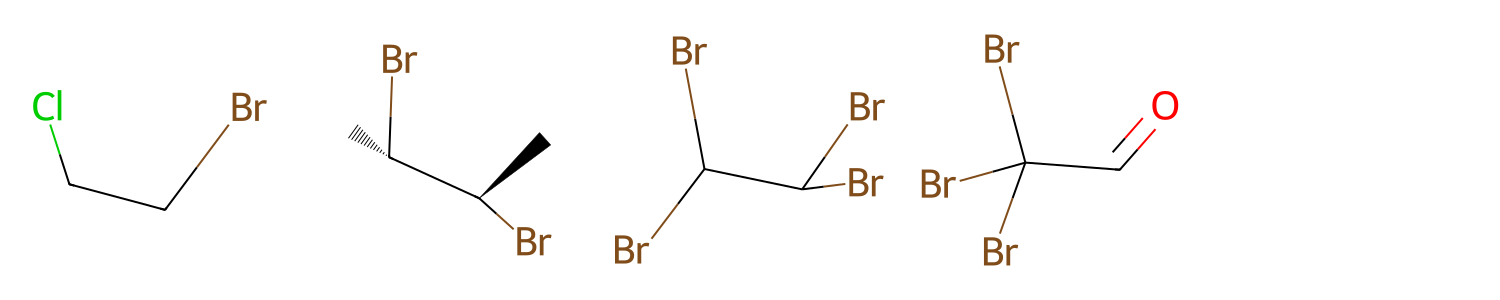

In [253]:
molblocks = [x[0] for x in querie.values()]
mols = [Chem.MolFromMolBlock(x) for x in molblocks]
Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(300,300))

In [263]:
query_string = f"""
SELECT molregno, conf_id
FROM conformers
WHERE molregno IN {tuple(wierd_molregnos_not_in_test)};
"""
data = query(query_string)
data

[(109, 1254),
 (3248, 3246),
 (3951, 3949),
 (109, 6721),
 (109, 6719),
 (109, 6720),
 (3951, 8276),
 (3951, 8278),
 (3951, 8277),
 (16740, 17275),
 (3248, 9858),
 (3248, 9859),
 (3248, 9856),
 (3248, 9857),
 (16740, 16738),
 (3951, 17305),
 (3248, 17316),
 (109, 17333)]

In [268]:
query_string = f"""
SELECT mdfp, md_experiment_uuid, conf_id
FROM cs_mdfps_schema.mdfp_experiment_data
WHERE conf_id IN {tuple(confids)};
"""
data = query(query_string)
data

[({'mdfp': '[4, 1, 0, 0, 0, 0, 0, 1, 1, 0, 2.0953226426886893, 1.0630604130473953, 2.144359610053673, 0.8112254927164844, 1.2229329622317384, 0.43936228642319686, -19.733297075148258, 7.238295120453924, -19.663822452714957, -33.75875885559798, 5.445962890058485, -34.54383124862866, 2.906548135405174, 1.9126036101597388, 2.509684281660265, -53.49205593074624, 8.211556536911678, -53.9694922993616, 0.20086026465927642, 0.003305676767110135, 0.2006580617247022, 2.3654788, 0.014913022, 2.3651352]'},
  'fc57851e-b654-4338-bcdd-faa28ec66253',
  1254),
 ({'mdfp': '[6, 1, 0, 0, 0, 0, 0, 0, 2, 0, -4.698618843629898, 0.7082452674810731, -4.680935742573204, 7.676482216873998, 3.70608088272733, 7.211652566789207, -22.95175036934446, 7.043080129923103, -23.00289179429974, -42.146497609155254, 6.3139699082752525, -42.82526760140984, 2.9778633732440976, 3.8098189432497644, 2.525082820555503, -65.09824797849971, 8.895169778276719, -65.03385740617821, 0.23565411025625538, 0.002741671130538205, 0.2356588

In [269]:
confids_with_mdfps = [x[2] for x in data]
confids_with_mdfps

[1254,
 3246,
 3949,
 6719,
 6720,
 6721,
 8276,
 8277,
 8278,
 9856,
 9857,
 9858,
 9859,
 1254,
 3246,
 3949,
 16738]

In [ ]:
#given [(109, 1254),
#  (3248, 3246),
#  (3951, 3949),
#  (109, 6721),
#  (109, 6719),
#  (109, 6720),
#  (3951, 8276),
#  (3951, 8278),
#  (3951, 8277),
#  (16740, 17275), ****
#  (3248, 9858),
#  (3248, 9859),
#  (3248, 9856),
#  (3248, 9857),
#  (16740, 16738),
#  (3951, 17305), *****
#  (3248, 17316), *****
#  (109, 17333)] ***

In [ ]:
#get confids for wierd_molregnos_not_in_test
confids = []
for molregno in wierd_molregnos_not_in_test:
    hits = lwreg.query(ids=[molregno],config=config)
    confids.append(hits[0])

In [ ]:
#perhaps a stereo thing?